# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [37]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for lr in np.logspace(-9,-7,5):
    for rs in np.logspace(4,7,5):
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                              num_iters=500, verbose=True)
        
        Yt = svm.predict(X_train_feats)
        Yp = svm.predict(X_val_feats)
        
        t_num_correct = np.sum(Yt == y_train)
        t_accuracy = float(t_num_correct) / X_train.shape[0]
        
        v_num_correct = np.sum(Yp == y_val)
        v_accuracy = float(v_num_correct) / X_val.shape[0]
        
        results[(lr,rs)] = (t_accuracy ,v_accuracy)
        
        if (best_val<v_accuracy):
            best_val = v_accuracy
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 500: loss 24.247841
iteration 100 / 500: loss 24.197395
iteration 200 / 500: loss 24.129304
iteration 300 / 500: loss 24.082657
iteration 400 / 500: loss 24.020274
iteration 0 / 500: loss 97.159907
iteration 100 / 500: loss 95.187188
iteration 200 / 500: loss 93.295546
iteration 300 / 500: loss 91.410259
iteration 400 / 500: loss 89.588604
iteration 0 / 500: loss 478.984965
iteration 100 / 500: loss 423.128552
iteration 200 / 500: loss 373.889722
iteration 300 / 500: loss 330.533929
iteration 400 / 500: loss 292.313041
iteration 0 / 500: loss 2770.260587
iteration 100 / 500: loss 1363.059560
iteration 200 / 500: loss 672.998847
iteration 300 / 500: loss 334.608074
iteration 400 / 500: loss 168.672572
iteration 0 / 500: loss 14996.560291
iteration 100 / 500: loss 272.601407
iteration 200 / 500: loss 13.636299
iteration 300 / 500: loss 9.081517
iteration 400 / 500: loss 9.001434
iteration 0 / 500: loss 24.768814
iteration 100 / 500: loss 24.571532
iteration 200 / 500: loss 

In [13]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.405


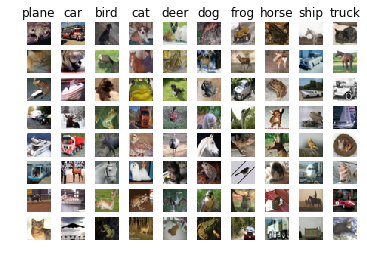

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [15]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

regularization_strengths = [0.1, 0.3]
results = {}
best_val = -1 
input_size = 32 * 32 * 3
num_classes = 10

#ranges
lr_range = np.linspace(1e-5,9e-5,15)
rs_range = np.linspace(regularization_strengths[0],regularization_strengths[1],5)
iters_range = [1500]

#initial values
best_lr = lr_range[0]
best_rs = rs_range[0]
best_iters = iters_range[0]
best_stats=None

#track progress
combinations = len(lr_range) + len(rs_range) + len(iters_range) -2
c=1

#sweep lr holding others constant
for lr in lr_range:
    print("Trying combination",c,"out of",combinations,"...")
    c+=1
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=best_iters, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.95,
        reg=best_rs, verbose=True)

    t_accuracy = stats["train_acc_history"][-1]
    v_accuracy = stats["val_acc_history"][-1]

    results[(lr,best_rs,best_iters)] = (t_accuracy ,v_accuracy)

    if (best_val<v_accuracy):
        best_val = v_accuracy
        best_net = net
        best_lr = lr
        best_stats = stats

#sweep rs holding others constant    
for rs in rs_range[1:]:
    print("Trying combination",c,"out of",combinations,"...")
    c+=1
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=best_iters, batch_size=200,
        learning_rate=best_lr, learning_rate_decay=0.95,
        reg=rs, verbose=True)

    t_accuracy = stats["train_acc_history"][-1]
    v_accuracy = stats["val_acc_history"][-1]

    results[(best_lr,rs,best_iters)] = (t_accuracy ,v_accuracy)

    if (best_val<v_accuracy):
        best_val = v_accuracy
        best_net = net
        best_rs = rs
        best_stats = stats

#sweep iters holding others constant
for iters in iters_range[1:]:
    print("Trying combination",c,"out of",combinations,"...")
    c+=1
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=iters, batch_size=200,
        learning_rate=best_lr, learning_rate_decay=0.95,
        reg=best_rs, verbose=True)

    t_accuracy = stats["train_acc_history"][-1]
    v_accuracy = stats["val_acc_history"][-1]

    results[(best_lr,best_rs,iters)] = (t_accuracy ,v_accuracy)

    if (best_val<v_accuracy):
        best_val = v_accuracy
        best_net = net
        best_iters = iters
        best_stats = stats
 
# Print out results.
for lr, rs, iters in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs, iters)]
    print('lr %e rs %e iters %d train accuracy: %f val accuracy: %f' % (
                lr, rs, iters, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best parameters: lr %e rs %e iters %d' % (
                best_lr, best_rs, best_iters))

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplots_adjust(hspace=0.8)

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history: lr %e rs %e iters %d' % (
                best_lr, best_rs, best_iters))
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Trying combination 1 out of 19 ...
iteration 0 / 1500: loss 2.302667
iteration 100 / 1500: loss 2.302667
iteration 200 / 1500: loss 2.302667
iteration 300 / 1500: loss 2.302667
iteration 400 / 1500: loss 2.302667
iteration 500 / 1500: loss 2.302666
iteration 600 / 1500: loss 2.302667
iteration 700 / 1500: loss 2.302666
iteration 800 / 1500: loss 2.302667
iteration 900 / 1500: loss 2.302666
iteration 1000 / 1500: loss 2.302666
iteration 1100 / 1500: loss 2.302667
iteration 1200 / 1500: loss 2.302666
iteration 1300 / 1500: loss 2.302666
iteration 1400 / 1500: loss 2.302667
Trying combination 2 out of 19 ...
iteration 0 / 1500: loss 2.302666
iteration 100 / 1500: loss 2.302666
iteration 200 / 1500: loss 2.302666
iteration 300 / 1500: loss 2.302666
iteration 400 / 1500: loss 2.302666
iteration 500 / 1500: loss 2.302666
iteration 600 / 1500: loss 2.302667
iteration 700 / 1500: loss 2.302667
iteration 800 / 1500: loss 2.302666
iteration 900 / 1500: loss 2.302665
iteration 1000 / 1500: loss 2

In [51]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.109


#### 